# ALeRCE variable stars starter notebook

```Authors: Alejandra Muñoz Arancibia, Lorena Hernandez Garcia, Last updated: 20211222```

ALeRCE starter notebook for variable stars science using the alerce client and a direct database connection.

For more information about the ALeRCE broker, please visit http://alerce.science/, or read our publications:
* The Automatic Learning for the Rapid Classification of Events (ALeRCE) Alert Broker, [Förster et al. 2021, AJ, 161, 242](https://arxiv.org/abs/2008.03303)
* Alert Classification for the ALeRCE Broker System: The Real-time Stamp Classifier, [Carrasco-Davis et al. 2021, AJ, 162, 231](https://arxiv.org/abs/2008.03309)
* Alert Classification for the ALeRCE Broker System: The Light Curve Classifier, [Sánchez-Sáez et al. 2021, AJ, 161, 141](https://arxiv.org/abs/2008.03311)

Note that this notebook can be run in Google Colab, uncommenting the lines in the following cell. They are presented later in the notebook but displayed also here for simplicity.

In [ ]:
#!pip install alerce
#!pip install astroquery
#!pip install git+https://github.com/phuijse/P4J/

In [1]:
# Set cell width to 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

We provide a Python client for easier access to the ALeRCE API services. It can be installed via pip and is documented in https://alerce.readthedocs.io/en/latest/. Uncomment in case you need to install.

In [2]:
#!pip install alerce

# Table of contents:
* [Introduction](#intro)
    * [Classifiers and taxonomies in ALeRCE](#classifiers)
* [Requirements](#req)
* [ALeRCE client](#client)
* [Query one target](#onetarget)
    * [Simple light curve](#simplelightcurve)
    * [Extinction corrected light curve](#advancedlightcurve)
    * [Simple period](#simpleperiod)
    * [Query image from Aladin](#oneimage)
* [Query a sample of targets](#sampletarget)
    * [Examples on how to use the ALeRCE client and database](#examplesample)
        * [Using the ALeRCE client to study a sample of RRL from their oid](#liuetal)
            * [Plot the light curves](#samplelightcurve)
            * [Plot the extinction corrected light curves](#sampleextlightcurve)
            * [Plot folded light curves and periodograms](#samplefoldedlightcurve)
            * [Query images from Aladin](#sampleimage)
            * [Estimate distances using the intensity-mean magnitude](#distances)
            * [Plots of the sample properties](#sampleproperties)
        * [Using the ALeRCE client to query a larger sample of RRL](#clientrrl)
            * [Plot the light curve amplitude vs period](#amplitudevsperiod)
        * [Using the ALeRCE database (DB) to query a sample of RRL](#dbrrl)
            * [Query object computed features](#featuresrrl)

# Introduction <a class="anchor" id="intro"></a>

ALeRCE started to systematically classify the ZTF stream using machine learning with astrophysically motivated taxonomies
based on their light curves (Sánchez-Sáez et al. 2021) since March 2019, and on their image stamps (Carrasco-Davis et al. 2021) since July 2019. These classfiers are designed to balance the needs for a fast and simple classification with a subsequent, but more complex classification.

The hierarchical taxonomy used by the ALeRCE broker for classifying light curves is shown in the figure below (v1.0.0). This classiffier uses four models: one which separates transients, stochastic and periodic objects; another which separates transients into SNe Ia, SNe Ib/c, SNe II and Superluminous SNe; another which separates stochastic objects into novae/CVs, blazars, QSOs, AGNs and YSOs; and another which classiffies periodic stars into LPVs, Ceph, RRL, DSCT, Es or Periodic-Other. In total, the ALeRCE broker classifies objects into a taxonomy that has expanded into 15 classes, and with continuously improving precision and purity. Note that all of ALeRCE's data products can be accessed freely via several dashboards, APIs, or a direct database connection.

![taxonomy_tree](https://github.com/alercebroker/usecases/blob/master/notebooks/variablestars_figures/taxonomy_tree.png?raw=1)

## Classifiers and taxonomies in ALeRCE <a class="anchor" id="classifiers"></a>

There are two classifiers used in ALeRCE, and each of them has its own taxonomy, which is more refined for the light curve classifier.

1. A stamp based classifier (Carrasco-Davis et al. 2021), which classifies objects based on their first image stamps. The purpose of this classifier is to differentiate five different classes between Active Galactic Nucleus (AGN), Supernovae (SN), Variable Star (VS), Asteroid, or Bogus.

The stamp classifier contains the following classes (see the image in [Introduction](#intro)):

*    `AGN`
*    `SN`
*    `VS`
*    `asteroid`
*    `bogus`


2. A light curve based classifier (Sánchez-Sáez et al. 2021), which classifies objects based on their light curve. The purpose of this classifier is to provide a more refined classification starting with at least 6 detections in a given band.
    
The light curve classifier uses the light curve information and contains the following classes (see the image in [Introduction](#intro)):

* `SNIa`
* `SNIbc`
* `SNII`
* `SLSN`
* `QSO`
* `AGN`
* `Blazar`
* `CV/Nova`
* `YSO`
* `LPV`
* `E`
* `DSCT`
* `RRL`
* `CEP`
* `Periodic-Other`

In particular, the light curve classifier considers the following classes of periodic variable stars:

- Long-Period Variable (LPV; includes regular, semi-regular, and irregular variable stars)

- RR Lyrae (RRL)

- Cepheid (CEP)

- Eclipsing binary (E)

- Delta Scuti (DSCT)

- Other periodic variable star (Periodic-Other; that includes classes of variable stars that are not well represented in the labeled set, e.g., sources classified as Hump, Misc, PCEB, Rotational, and RS CVn in CRTS).

And the following classes of stochastic variable stars:

- Young Stellar Objects (YSO)

- Nova/Cataclismic Variable (CV)

The confusion matrix from Sánchez-Sáez et al. (2021) shows that the light curve classifier has a very good performance separating periodic classes:

![SanchezSaez+2020_confusion](https://github.com/alercebroker/usecases/blob/master/notebooks/variablestars_figures/SanchezSaez+2020_confusion.png?raw=1)

In this notebook we will query data from a single variable star in order to plot its light curve, which is later corrected by extinction. Because these stars show periodic variability, we will plot their folded light curve and periodograms, thus we will be able to estimate their period. We will also see its image stamp, and visualize it in Aladin to explore its environment.

Then, we will show how to query a sample of variable stars using the ALeRCE client or the database (for big samples), showing their light curves and plotting different properties of the sample.

# Requirements <a class="anchor" id="req"></a>

In the following we specify the required packages to run this Notebook. Some of the packages are included in Python and others require installation. Uncomment in case you need to install.

Basic Requirements

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Astropy and astroquery

In [4]:
#!pip install astroquery

In [5]:
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from astropy.table import Table, Column
from astroquery.irsa_dust import IrsaDust
from astroquery.simbad import Simbad

Install psycopg2 https://github.com/psycopg/psycopg2

In [6]:
#!pip install psycopg2-binary

In [7]:
import psycopg2

Install P4J (https://pypi.org/project/P4J/). Note that this notebook uses a experimental version of P4J, which can be cloned and installed (`python setup.py install --user`) from https://github.com/phuijse/P4J/.

In [8]:
#!pip install git+https://github.com/phuijse/P4J/
import P4J

Other

In [9]:
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

# ALeRCE client <a class="anchor" id="client"></a>

To import the ALeRCE API client:

In [10]:
from alerce.core import Alerce
client = Alerce()

In [11]:
# Color blind friendly green and red 
colors = {1: '#56E03A', 2: '#D42F4B'}

# Query one target <a class="anchor" id="onetarget"></a>

For this example, we selected a star classified as RR Lyrae in The Catalina Surveys RR Lyrae Data Release (http://nesssi.cacr.caltech.edu/DataRelease/RRL.html). The name of the star is V0420_Peg__ (CSS_J000018.2+193253 in the catalog). The RRL is located at RA = 00:00:18.200, DEC = +19:32:55.46.

Drake et al. (2013, ApJ, 763, 32) analyzed this survey, concentrated on the data taken by the Catalina Survey Schmidt 0.7m telescope (CSS) between April 2005 and June 2011, and reported the following properties for the star:

V magnitude = 15.664  mag

Period = 0.5454725 days (they find that the periods at generally accurate to sigma = 0.002%)

Amplitude = 0.85  mag

Number of points in the light curve = 211   

Distance = 9.73 kpc

Extinction = 0.088 mag

The name of this RRL in the ZTF is ZTF18abnznbm. Note that this light curve and the properties of this star can also be accessed through the Explorer: https://alerce.online/object/ZTF18abnznbm

In the following we will obtain and analyze the ZTF light curve of ZTF18abnznbm processed by the ALeRCE broker, and we will be able to compare the physical properties derived from this analysis with those already available in the literature.

## Simple light curve <a class="anchor" id="simplecurve"></a>

We start by manually defining the object identifier (oid) of the source we want to explore with the ALeRCE client:

In [12]:
seloid = "ZTF18abnznbm"

We will first create a function that plots the difference magnitude light curve. We only do this step to show the difference light curve, but we notice that this MUST be corrected (see below):

In [13]:
def plot_diffLC(oid, LC_det): 
    
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}
    
    # loop the passbands
    for fid in [1, 2]:
        
        # plot detections if available
        mask = LC_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(LC_det[mask].mjd, LC_det[mask].magpsf, 
                yerr=LC_det[mask].sigmapsf, c=colors[fid], marker=markers[fid], label=labels[fid],
                linestyle='None')
    
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Difference magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

Now we will create a function that plots the apparent magnitude light curve (an estimate of the science images light curve). These apparent magnitudes are computed by the ALeRCE pipeline by summing up the flux measured in the difference images ($f_{\rm diff}$) and the flux measured from the template image ($f_{\rm ref}$), taking into account whether the difference between the science and reference image in a given epoch ($\rm sgn$) is positive or negative (for more details, see the appendix A in Förster et al. 2021):

$$
    \hat f_{\rm sci} = f_{\rm ref} + {\rm sgn}~ f_{\rm diff}
$$

In [14]:
def plotLC(oid, VS_det):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    
    # loop the passbands
    for fid in [1, 2]:
        
        # plot detections if available
        mask = VS_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr, 
                yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                linestyle='None')
        
            
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

Then, we will create a function that only gets the light curve data and plots the light curve if required, the results are then returned to the user as a dictionary. Note that we use the client to query the detections and that we return the results in pandas format (default is votable).

In [15]:
def getVSdata(oid, doLC=False):

    results = {"oid": oid}
    
    # query basic stats
    VS_stats = client.query_object(oid, format='pandas')
    results["stats"] = VS_stats
    
    # query magnitude stats
    VS_magstats = client.query_magstats(oid, format='pandas')
    results["magstats"] = VS_magstats
    
    # query detections
    VS_det = client.query_detections(oid, format='pandas')
    VS_det = VS_det.sort_values("mjd")
    results["lc_det"] = VS_det
    
    # plot the LC
    if doLC:
        plotLC(oid, VS_det)
        
    # return data
    return results

And now we can show the object's light curve:

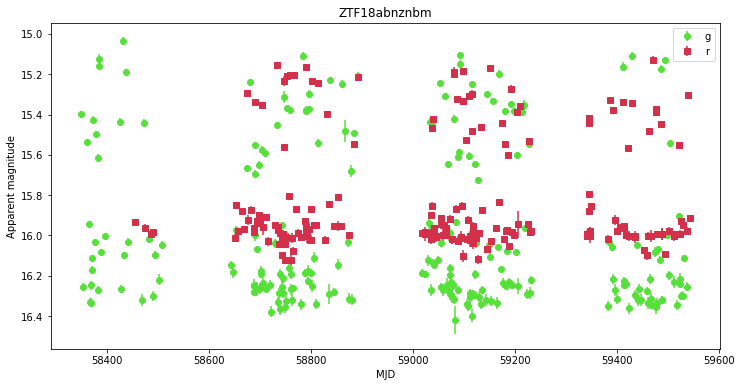

In [16]:
results = getVSdata(seloid, doLC=True)

The first detections of this light curve were obtained on Aug 19th 2018 (g filter) and Dec 4th 2018 (r filter). 

Just out of curiosity, let's display the light curve using difference magnitudes (which should NOT be used for variable stars):

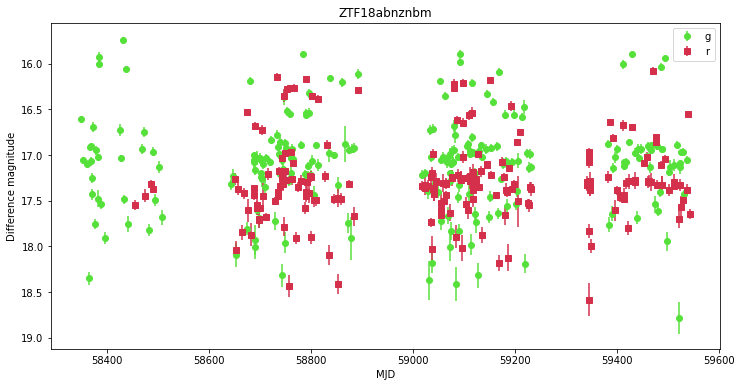

In [17]:
plot_diffLC(seloid, results["lc_det"])

Note that the shape of the light curves look slightly different. This is because the difference light curve uses the flux measurement directly from the difference image (each pixel in the difference image is obtained from the absolute value of the difference between the science and reference images i.e., flux(|science-reference|)). In the science light curve, the reference image and whether the difference between the science and reference image in a given epoch ($\rm sgn$) is positive or negative are taken into account.

This is more noticeable in LPVs, so let's see an example:

In [18]:
seloidLPV = "ZTF18aazelzb"

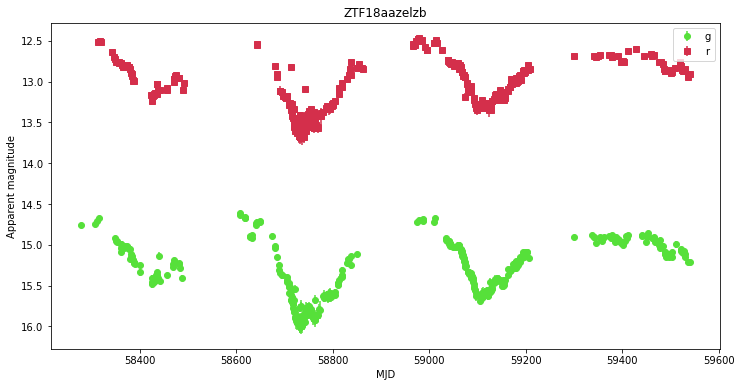

In [19]:
results = getVSdata(seloidLPV, doLC=True)

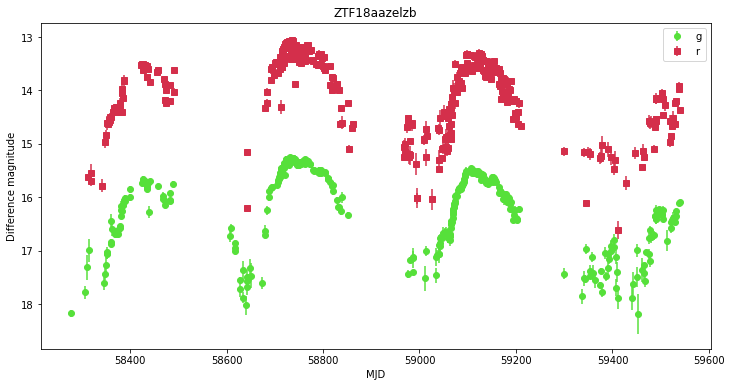

In [20]:
plot_diffLC(seloidLPV, results["lc_det"])

## Extinction corrected light curve <a class="anchor" id="advancedlightcurve"></a>

We will correct the light curve for extinction using extinction mapping. For this purpose we will modify the above light curve using a dictionary with attenuations due to Galactic extinction. Note that we use astroquery SIMBAD objects, as well as mag units.

In [21]:
def plotLCcorr(oid, VS_det, A=None):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 40}
    
    # loop the passbands
    for fid in [1, 2]:
        
        # galactic extinction in the given band
        if A is not None:
            A_fid = A[labels[fid]]
        else:
            A_fid = 0

        # plot detections if available
        mask = VS_det.fid == fid
        if np.sum(mask) > 0:
            
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            if A_fid != 0:
                # plot attenuated light curve with small alpha
                ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr,
                    yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                    alpha=0.1, linestyle='None')
                # show dust attenuation corrected light curve
                ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr - A_fid, 
                    yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid],
                    label="%s (ext. corr.)" % labels[fid], linestyle='None')
            else:
                # plot attenuated light curve
                ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr,
                    yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                    linestyle='None')
    
    # labels
    if A is not None:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$)" % (oid, A["g"], A["r"]))
    else:
        ax.set_title(oid)
        
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

We will also modify the getVSdata function to get all the necessary information given the object id (oid). It now does the following:
 - get the basic VS statistics, this includes the position in the sky (using the ALeRCE client)
 - get the detections (using the ALeRCE client)
 - get the dust attenuation at the given position in the sky (using astroquery IrsaDust)
 - get a cross-match with SIMBAD for a given search radius (using astroquery Simbad)
 - plot the apparent magnitude light curve corrected for dust attenuation (using the previously defined function)
 - plot the first image stamps associated to this VS (using the ALeRCE client)

In [22]:
def getVSdatacorr(oid, doLC=False, doext=False, dostamp=False, dosimbad=False, showlink=False):

    results = {"oid": oid}
    
    # query basic stats
    VS_stats = client.query_object(oid, format='pandas')
    results["stats"] = VS_stats
    
    # query magnitude stats
    VS_magstats = client.query_magstats(oid, format='pandas')
    results["magstats"] = VS_magstats
    
    # query detections
    VS_det = client.query_detections(oid, format='pandas')
    VS_det = VS_det.sort_values("mjd")
    results["lc_det"] = VS_det
        
    # object coordinates
    co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),
                              frame='icrs')
    
    # get SIMBAD query
    if dosimbad:
        Simbad_table = Simbad.query_region(co, radius=0.01 * u.deg, equinox=2000)
        display(Simbad_table)
        results["simbad_table"] = Simbad_table
    
    # get Galactic extinction
    if doext:
        # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
        table = IrsaDust.get_extinction_table(co)
        A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]),
             "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
        results["attenuation"] = A

    # plot the LC
    if doLC:
        if doext:
            plotLCcorr(oid, VS_det, A)
        else:
            plotLCcorr(oid, VS_det)        
    
    if showlink:
        display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))
    
    # show the first image stamp
    if dostamp:
        candid = results["lc_det"].loc[results["lc_det"].has_stamp].candid.min()
        stamps = client.get_stamps(oid, candid)
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
        fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
        for idx, im in enumerate([np.log(science), np.log(ref), difference]):
            ax[idx].imshow(im, cmap='viridis') # Log scale for visualization
            ax[idx].axes.get_xaxis().set_visible(False)
            ax[idx].axes.get_yaxis().set_visible(False)
        ax[0].set_title("oid: %s, candid: %s (science, reference and difference)" % (oid, candid), loc='left')
        fig.subplots_adjust(wspace=0, hspace=0)
        
    return results

And now we can show the extinction corrected light curve and its stamp:

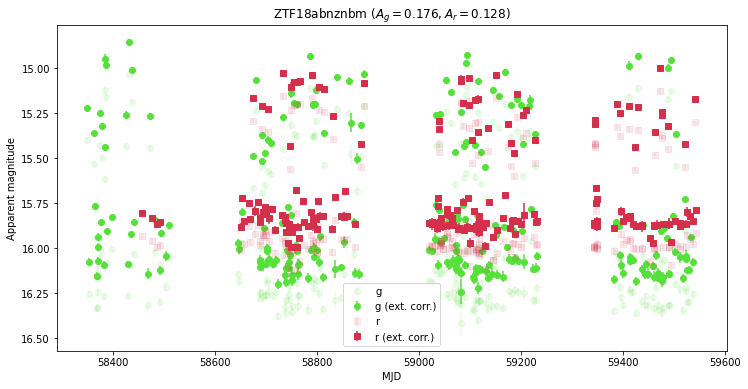

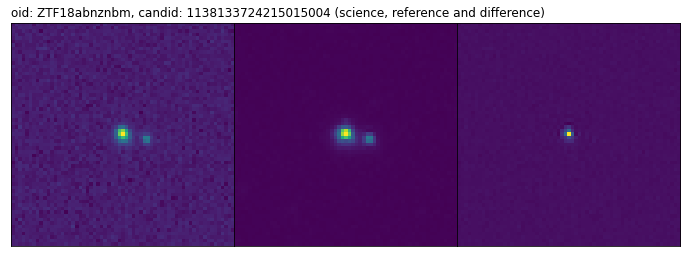

In [23]:
results = getVSdatacorr(seloid, doLC=True, doext=True, dostamp=True, showlink=True)

## Simple period <a class="anchor" id="simpleperiod"></a>

Because RRL are periodic objects, the light curves shown above are not too informative, thus we will plot the folded light curve and obtain three different periodograms, the multiband period, the period in the g filter, and in the r filter.

We will use P4J to calculate the periodograms (https://github.com/phuijse/P4J). P4J is a python package for period detection on irregularly sampled and heteroscedastic time series based on Information Theoretic objective functions. P4J was developed for astronomical light curves, irregularly sampled time series of stellar magnitude or flux. The core of the used package is a class called periodogram that sweeps an array of periods/frequencies looking for the one that maximizes a given criterion. The main contribution of this work is a criterion for period detection based on the maximization of Cauchy-Schwarz Quadratic Mutual Information (Huijse et al. 2018, ApJS, 236, 12). Information theoretic criteria incorporate information on the whole probability density function of the process and are more robust than classical second-order statistics based criteria (Principe 2010). For comparison P4J also incorporates other period detection methods used in astronomy such as the Phase Dispersion Minimization periodogram (Stellingwerf 1973), Lafler-Kinman's string length (Clarke 2002) and the Orthogonal multiharmonic Analysis of Variance periodogram (Schwarzenberg-Czerny 1996).

We will also obtain the multiband period using the Multi Harmonic Analysis of Variance (MHAOV) periodogram (Mondrik et al. 2015, ApJL, 811, L34), using both g and r bands at the same time. We use this method since it provides a good trade-off between performance and computational complexity (see Sánchez-Sáez et al. 2021 for details), and for comparison purposes.

First we define the function to get the period of the star:

Note here that the user can modify the values of the parameters `fmin`, `fmax`, `fresolution` and `n_local_optima`.

In [24]:
def doperiod_multiband(VS_det, showperiod=False):
    
    mjds, mags, errs, fids = VS_det[["mjd", "magpsf_corr", "sigmapsf_corr_ext", "fid"]].dropna().values.T
    
    # Compute periodogram
    my_per = P4J.MultiBandPeriodogram(method='MHAOV')
    my_per.set_data(mjds, mags, errs, fids)        
    my_per.frequency_grid_evaluation(fmin=1e-3, fmax=20.0, fresolution=1e-3)
    my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)
    
    best_freq, best_per = my_per.get_best_frequencies()
    freq_mb, per_mb = my_per.get_periodogram()
    period_mb = 1.0 / best_freq[0]
    
    if showperiod:
        print('Multiband period: %.6f days' % period_mb)
    
    period = {}
    freq = {}
    per = {}
    labels = {1: 'g', 2: 'r'}
    
    for fid in [1, 2]:
        freq[fid], per[fid] = my_per.get_periodogram(fid)
        best_freq = my_per.get_best_frequency(fid)
        period[fid] = 1. / best_freq
        
        if showperiod:
            print("Period %s: %.6f days" % (labels[fid], period[fid]))
    
    return period_mb, freq_mb, per_mb, period, freq, per

Now define the function to be plotted:

In [25]:
def plotperiod_multiband(oid, VS_det, dofold=False, showperiodograms=False,
                         period_mb=None, freq_mb=None, per_mb=None,
                         period=None, freq=None, per=None):

    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 40}
    
    for idx, fid in enumerate([1, 2]):
        maskdet = VS_det.fid == fid
        
        if dofold:
            phase = np.mod(VS_det[maskdet].mjd, period_mb) / period_mb
            for nphase in [0, 1]:
                if nphase == 0:
                    label = labels[fid]
                else:
                    label = None
                ax.errorbar(phase + nphase, VS_det[maskdet].magpsf_corr, 
                        yerr = VS_det[maskdet].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=label,
                        markersize=5, linestyle='None')
        else:
            ax.errorbar(VS_det[maskdet].mjd, VS_det[maskdet].magpsf_corr, 
                    yerr=VS_det[maskdet].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                    linestyle='None')
    
    if dofold:
        ax.set_title("%s (multiband period: %.6f days)" % (oid, period_mb))
        ax.set_xlabel("phase")
    else:
        ax.set_title(oid)
        ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    if dofold and showperiodograms:
        fig, ax = plt.subplots(ncols=3, figsize=(14, 4))
        
        for idx, fid in enumerate([0, 1, 2]):
            if idx==0:
                ax[idx].plot(freq_mb, per_mb)
                ax[idx].set_title("Multiband periodogram")
                ax[idx].set_xlabel("frequency [1/days]")
            else:
                ax[idx].plot(freq[fid], per[fid])
                ax[idx].set_title("Periodogram %s (period: %.6f days)" % (labels[fid], period[fid]))
                ax[idx].set_xlabel("frequency [1/days]")

Get data, fold, and plot:

In [26]:
def getLCdata(oid, results, doplot=False, dofold=False, showperiod=False, showperiodograms=False):
    if dofold:
        # get period
        period_mb, freq_mb, per_mb, period, freq, per = doperiod_multiband(results["lc_det"],
                                                                           showperiod=showperiod)
        results["period_multiband"] = period_mb
        results["period_band"] = period
    else:
        period = None; freq = None; per = None
        period_mb = None; freq_mb = None; per_mb = None
    
    if doplot:
        plotperiod_multiband(oid, results["lc_det"], dofold, showperiodograms,
                             period_mb=period_mb, freq_mb=freq_mb, per_mb=per_mb,
                             period=period, freq=freq, per=per)
        
    return results

We can plot the folded light curve and periodograms, and the respective periods are shown:

Multiband period: 0.545494 days
Period g: 0.545494 days
Period r: 0.545494 days


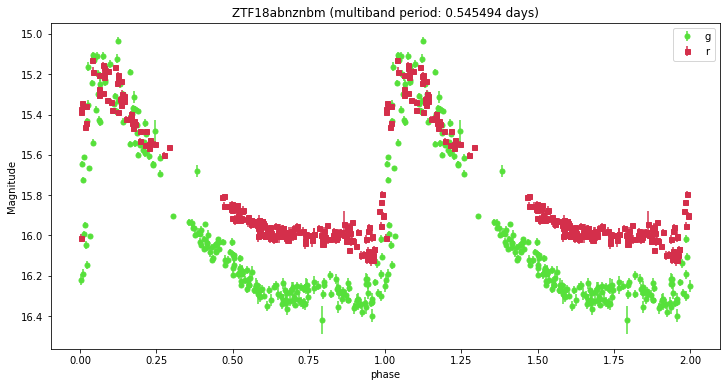

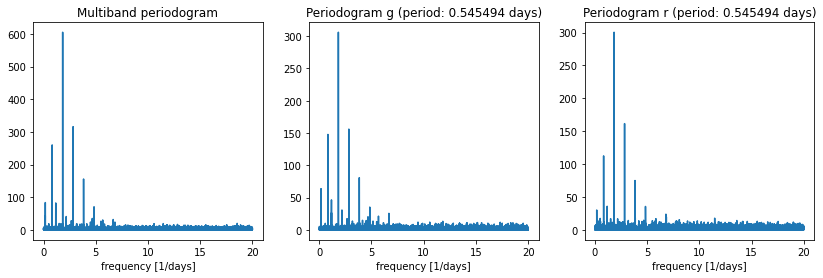

In [27]:
results = getVSdatacorr(seloid)
periodogram = getLCdata(seloid, results, doplot=True, dofold=True, showperiod=True, showperiodograms=True)

We estimated the period using the multiband periodogram, as well as individual periodograms for the filters g and r, and in all cases we obtained Period = 0.545494 days. If we compare with the work by Drake et al. (2013), they obtained Period = 0.5454725 days, thus in very good agreement. We can also check how does our light curve look adopting the period given by Drake et al. (2013):

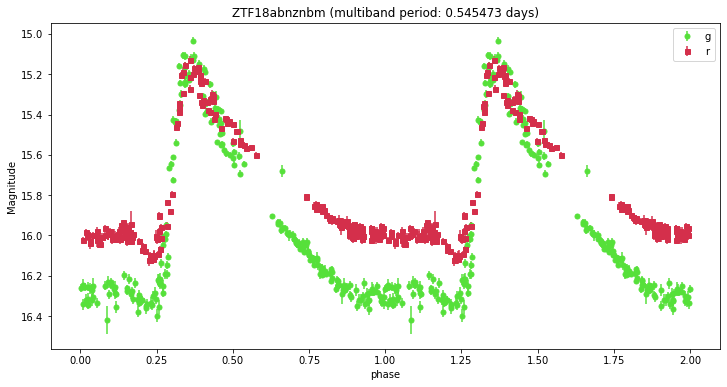

In [28]:
period_mb_test = 0.5454725
results = getVSdatacorr(seloid)
plotperiod_multiband(seloid, results["lc_det"], dofold=True, period_mb=period_mb_test)

We can also test different values for the parameters `fmin`, `fmax`, `fresolution` and `n_local_optima` in the computation of the periodogram:

Multiband period: 0.545477 days


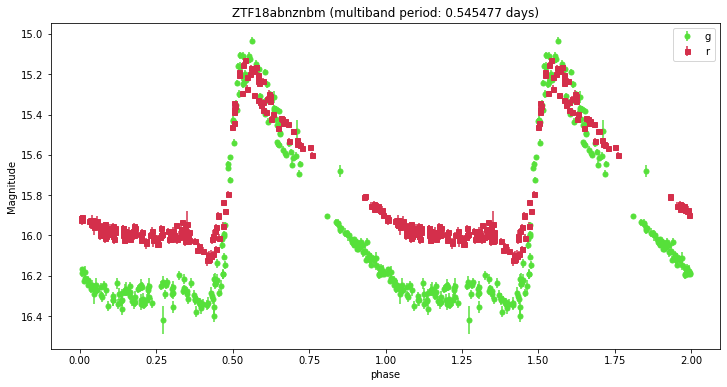

In [29]:
mjds, mags, errs, fids = results["lc_det"][["mjd", "magpsf_corr", "sigmapsf_corr_ext", "fid"]].dropna().values.T

# Compute periodogram
my_per = P4J.MultiBandPeriodogram(method='MHAOV')
my_per.set_data(mjds, mags, errs, fids)        
my_per.frequency_grid_evaluation(fmin=1e-3, fmax=10.0, fresolution=1e-4)
my_per.finetune_best_frequencies(fresolution=1e-5, n_local_optima=5)

best_freq, best_per = my_per.get_best_frequencies()
freq_mb, per_mb = my_per.get_periodogram()
period_mb = 1.0 / best_freq[0]
    
print('Multiband period: %.6f days' % period_mb)

plotperiod_multiband(seloid, results["lc_det"], dofold=True, period_mb=period_mb)

This RRL is also present in ASAS-SN: https://asas-sn.osu.edu/variables/ebab1536-9eea-5846-8981-6937bc875eb2 which shows results in very good agreement with those reported here.

From our analysis, we can state that this is an ab-type RR Lyrae star, as noted by its typical sawtooth-shaped light curve, period of order half a day, fast rise time (time between minimum and maximum), and shock-related bump before minimum light. 
Note that the color (g-r) can be directly inferred from the g and r light curves. The resulting values are typical of an RR Lyrae star that is not heavily affected by extinction, and which changes smoothly as a function of phase, as expected for this class of pulsating stars.

## Query image from Aladin <a class="anchor" id="oneimage"></a>

We can show an image from Aladin to see the star and its environment from a PanSTARRS DR1 image. We also display a table with cross-match(es) in the SIMBAD public database for our adopted search radius (0.01 deg).

In [30]:
def show_image(results):
    query = """
<!-- include Aladin Lite CSS file in the head section of your page -->
<link rel="stylesheet" href="https://aladin.u-strasbg.fr/AladinLite/api/v2/latest/aladin.min.css" />
 
<!-- you can skip the following line if your page already integrates the jQuery library -->
<script type="text/javascript" src="https://code.jquery.com/jquery-1.12.1.min.js" charset="utf-8"></script>
 
<!-- insert this snippet where you want Aladin Lite viewer to appear and after the loading of jQuery -->
<div id="aladin-lite-div" style="width:800px;height:400px;"></div>
<script type="text/javascript" src="https://aladin.u-strasbg.fr/AladinLite/api/v2/latest/aladin.min.js" charset="utf-8"></script>
<script type="text/javascript">
    var aladin = A.aladin('#aladin-lite-div', {survey: "P/PanSTARRS/DR1/color-z-zg-g", fov:0.04, target: "%s, %s"});
</script>
""" % (float(results["stats"].meanra), float(results["stats"].meandec))
    display(HTML(query))
    #print(query)

In [31]:
results = getVSdatacorr(seloid, dosimbad=True)
show_image(results)

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32
V* V420 Peg,00 00 18.1975,+19 32 55.448,14,14,0.051,0.024,90,A,O,2018yCat.1345....0G,1


# Query a sample of targets <a class="anchor" id="sampletarget"></a>

As explained in the [Introduction](#intro), ALeRCE systematically classifies the sources into a hierarchical [taxonomy](#classifiers), based on a stamp classifier which classifies in five subclasses, and a light curve classifier that is used when at least six detections are obtained in the light curve, which provides a more detailed classification up to 15 classes. In this part of the notebook we will show three different examples using the ALeRCE client and the database to query different samples of variable stars.

## Examples on how to use the ALeRCE client and database<a class="anchor" id="examplesample"></a>

In the following, we will explore three different options to query data from ALeRCE:

- [Using the ALeRCE client to study a sample of RRL taken from their oid](#liuetal)

- [Using the ALeRCE client to query a sample of RRL](#clientrrl)

- [Using the ALeRCE database (DB) to query a sample of RRL. Note that the DB allows more complex queries](#dbrrl)

### Using the ALeRCE client to study a sample of RRL from their oid <a class="anchor" id="liuetal"></a>

In this example, we want to use the sources in the sample of Liu et al. (2020, ApJS, 247, 68) with available data in ALeRCE to estimate their distances. From their sample of 21 RRL, six have data in the g or r filter, and four have data in both the g and r filters, thus in the following we will use these four RRL.

In this example we will use the ALeRCE client to query the sources. If you are not yet connected to the ALeRCE client, jump to [how to connect](#client).

First, we manually define the object identifiers of the sources we want to explore:

In [32]:
#seloid = ["ZTF17aabulmo", "ZTF18aajusiz", "ZTF18aalarzm", "ZTF18abiwdfa", "ZTF18aapmpdr", "ZTF18aapsyhm"] these are the six sources with data in g or r
seloid = [ "ZTF18aajusiz", "ZTF18aalarzm", "ZTF18aapmpdr", "ZTF18aapsyhm"] # these are the four RRL with data in both g and r

#### Plot the light curves <a class="anchor" id="samplelightcurve"></a>

We can plot their light curves:

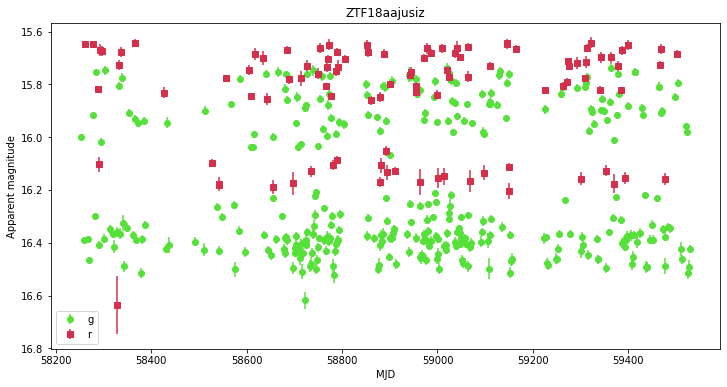

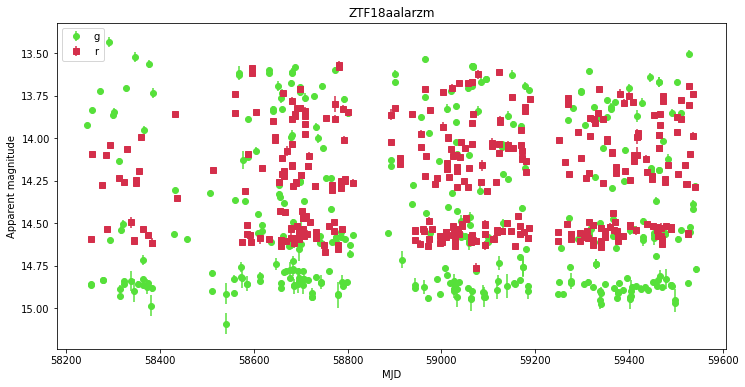

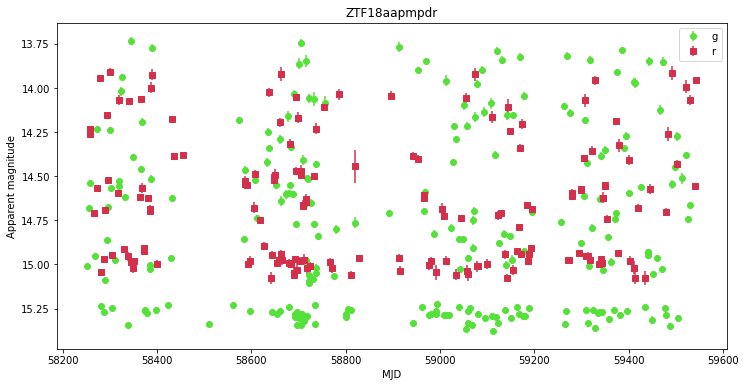

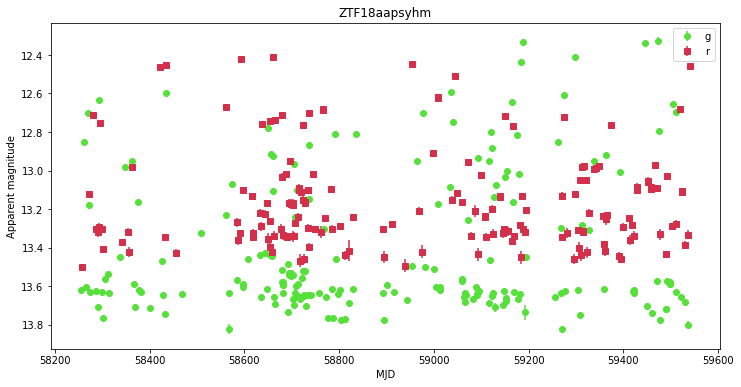

In [33]:
for oid in seloid:
    results = getVSdatacorr(oid, doLC=True)

#### Plot the extinction corrected light curves <a class="anchor" id="sampleextlightcurve"></a>

As well as their light curves corrected for extinction along with their stamps:

/home/ammunoz1/.local/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log


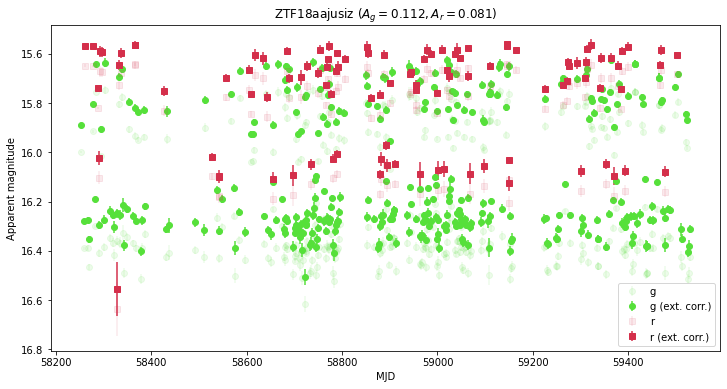

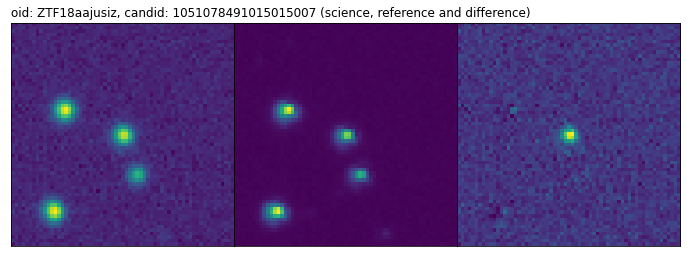

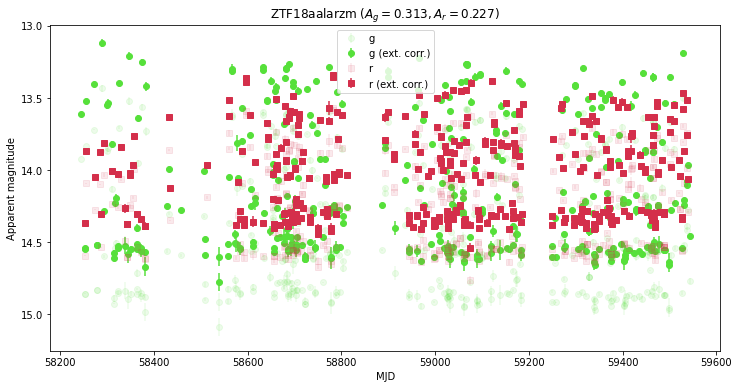

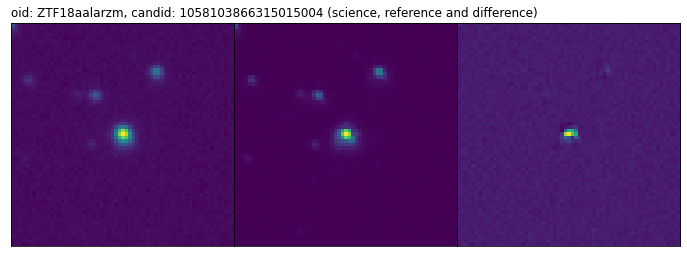

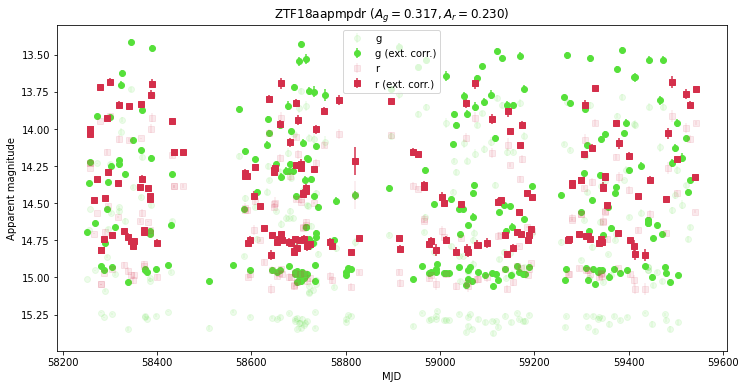

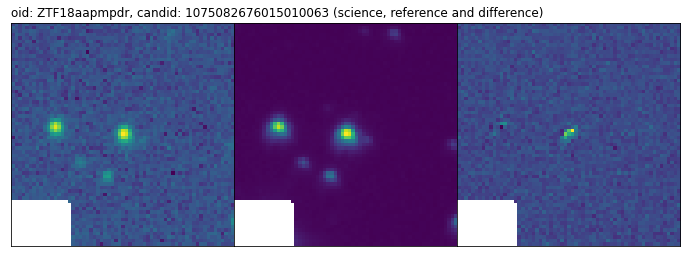

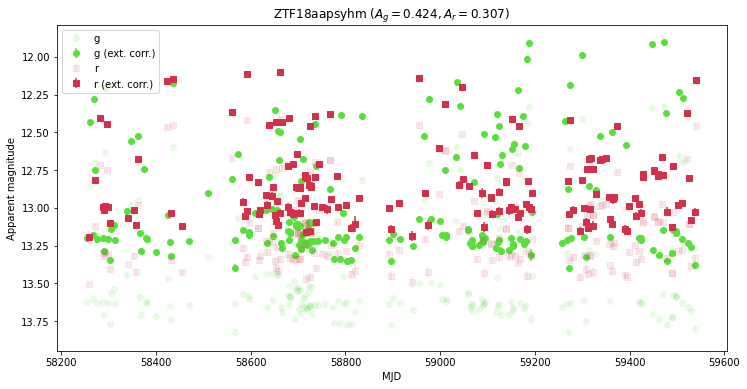

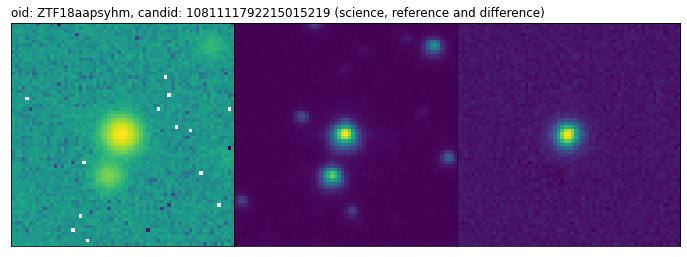

In [34]:
for oid in seloid:
    results = getVSdatacorr(oid, doLC=True, doext=True, dostamp=True)

#### Plot the folded light curves and periodograms <a class="anchor" id="samplefoldedlightcurve"></a>

And we also plot the folded light curves and periodograms, and estimate their periods:

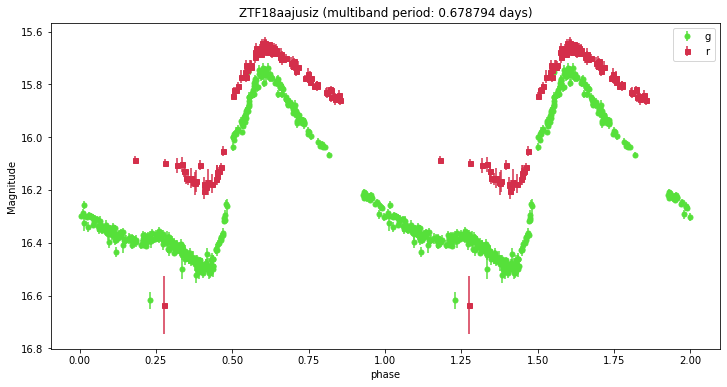

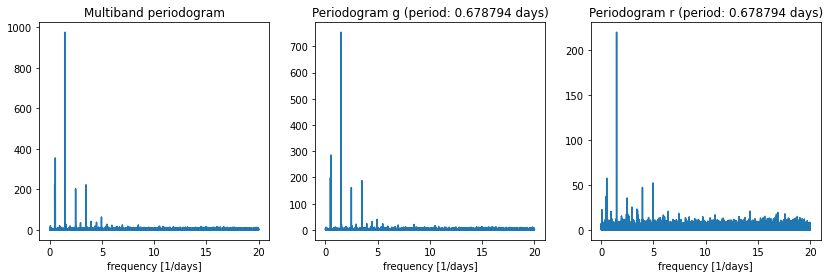

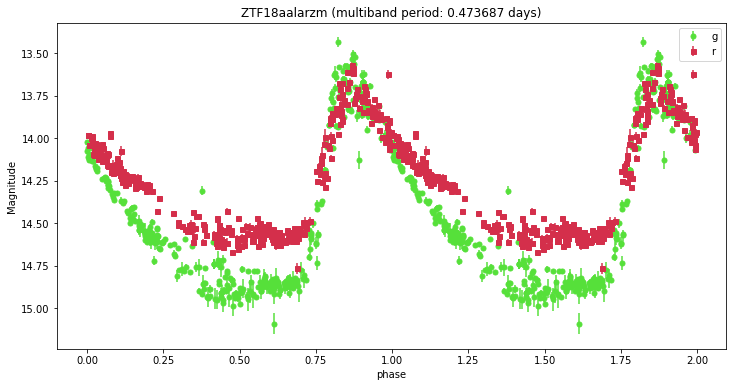

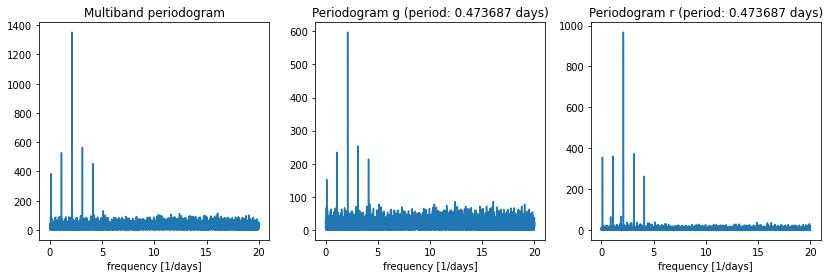

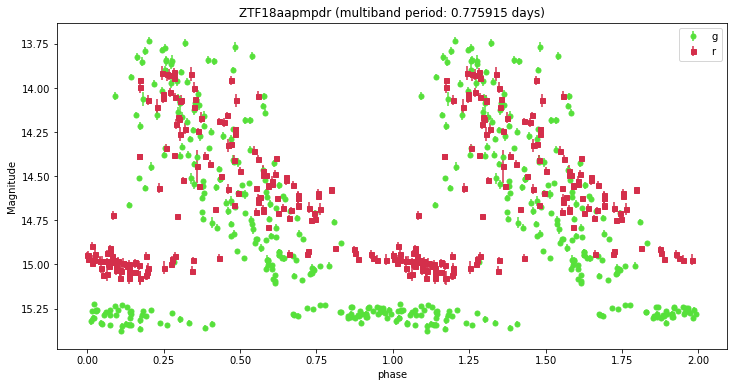

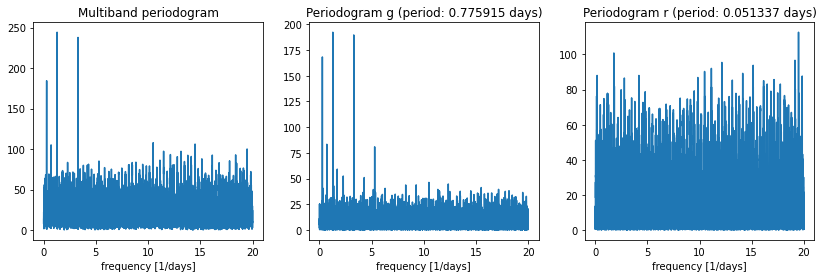

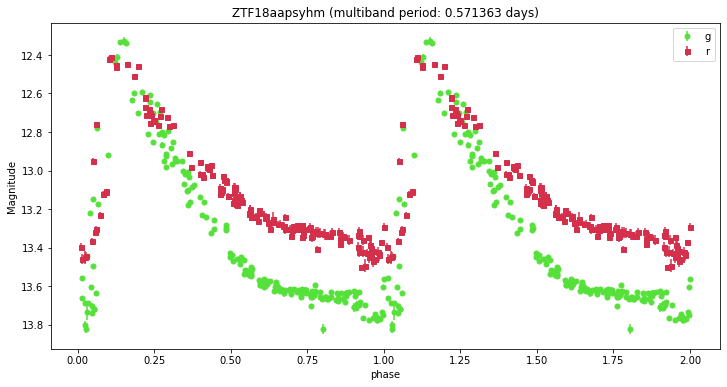

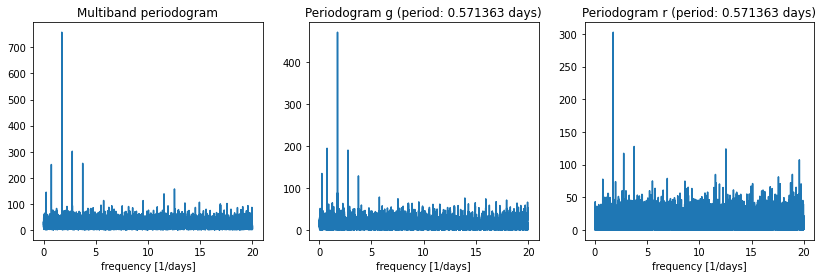

In [35]:
for oid in seloid:
    results = getVSdatacorr(oid)
    periodogram = getLCdata(oid, results, doplot=True, dofold=True, showperiodograms=True)

#### Query images from Aladin <a class="anchor" id="sampleimage"></a>

We can also query their PanSTARRS images from Aladin and get information from SIMBAD for each of the targets:

In [36]:
for oid in seloid:
    results = getVSdatacorr(oid, dosimbad=True)
    show_image(results)

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32
2MASS J17073392+5850598,17 07 33.9321,+58 50 59.711,14,14,0.033,0.034,90,A,O,2018yCat.1345....0G,1


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32
V* V355 Lyr,18 53 25.9146,+43 09 16.416,14,14,0.017,0.022,90,A,O,2018yCat.1345....0G,1


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32
V* V1104 Cyg,19 18 00.4921,+50 45 17.810,14,14,0.023,0.022,90,A,O,2018yCat.1345....0G,1


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32
V* V894 Cyg,19 33 00.9070,+46 14 22.883,14,14,0.015,0.016,90,A,O,2018yCat.1345....0G,1
BOKS 3771,19 33 02.0846,+46 14 28.032,14,14,0.085,0.085,90,A,O,2018yCat.1345....0G,1


#### Estimate distances using the intensity-mean magnitude <a class="anchor" id="distances"></a>

We will estimate the distance of the stars in the sample using the g and r filters and compare the distances. We will use the distance modulus (m - M) to obtain the distance. Distance and flux are related for two sources A and B as:

$F_A/F_B = (d_B/d_A)^2$

The relation between magnitude and flux is given by:

$m_B - m_A = 2.5 \log (F_A / F_B)$ 

Assuming the same star at different distances, we can obtain the distance as:

$d = 10^{0.2 (m - M + 5)}$ [pc]


where the apparent magnitude, m, is taken from the ZTF data (`mean_magpsf_corr`) which has been corrected for extinction. The absolute magnitude, M, is calculated following Catelan et al. (private communication), as follows:





$M_g = 1.646 + 0.307 * \log(Z)$

$M_r = 1.097 - 0.587 * \log(P) + 0.238 * \log(Z) $

where P refers to the period (in days), and $\log (Z)$ is estimated as:

$\log(Z) = [M/H] - 1.765 = [Fe/H] + \log(0.638 * f + 0.362) - 1.765 $


where $ f = 10^{[\alpha/Fe]} $

Here $[Fe/H]$ has been obtained from Table 3 in Liu et al. (2020), and $[\alpha/Fe]$ can be considered $\sim$ +0.3 because these stars have $[Fe/H] \lesssim$ -1 dex (Catelan et al., in prep.)

In [37]:
feh = [-2.92, -1.14, -1.23, -1.66]
afe = 0.3
f = 10**afe
mh = feh + np.log10(0.638 * f + 0.362)
logZ = mh - 1.765
#print("f =", f)
#print("[M/H] =", mh)
#print("log(Z) =", logZ)

noid = len(seloid)
mg = np.zeros(noid)
mr = np.zeros(noid)
period_mb = np.zeros(noid)
period_g = np.zeros(noid)
period_r = np.zeros(noid)

for i, oid in enumerate(seloid):
    results = getVSdatacorr(oid, doext=True)
    mg[i] = results["magstats"].magmean[0] - results["attenuation"]["g"]
    mr[i] = results["magstats"].magmean[1] - results["attenuation"]["r"]
    period_mb[i], freq_mb, per_mb, period, freq, per = doperiod_multiband(results["lc_det"])
    period_g[i] = period[1]
    period_r[i] = period[2]

Mg = 1.646 + 0.307 * logZ
Mr = 1.097 - 0.587 * np.log10(period_mb) + 0.238 * logZ

# Estimate distance using the m-d distance
dist_g = 10**(0.2 * (mg - Mg + 5.0))
dist_r = 10**(0.2 * (mr - Mr + 5.0))

Now we compute the maximum and mean colors, thus we obtain the colors from the "stats" table, that are later corrected by extinction:

In [38]:
g_r_max_corr_ext_att = np.zeros(noid)
g_r_mean_corr_ext_att = np.zeros(noid)

for i, oid in enumerate(seloid):
    results = getVSdatacorr(oid, doext=True, doLC=False, dostamp=False)
    g_r_max_corr_ext_att[i] = results["stats"].g_r_max_corr - results["attenuation"]["g"] + results["attenuation"]["r"]
    g_r_mean_corr_ext_att[i] = results["stats"].g_r_mean_corr - results["attenuation"]["g"] + results["attenuation"]["r"]

Now we gather the properties in a dataframe:

In [39]:
rrl_sample = pd.DataFrame(seloid, columns=['oid'])
rrl_sample['Mg'] = Mg # Absolute Magnitude g, M_g
rrl_sample['Mr'] = Mr # Absolute Magnitude r, M_r
rrl_sample['mg'] = mg # Apparent Magnitude g, m_g
rrl_sample['mr'] = mr # Apparent Magnitude r, m_r
rrl_sample['dist_g'] = dist_g # Distance g filter (pc)
rrl_sample['dist_r'] = dist_r # Distance r filter (pc)
rrl_sample['period_mb'] = period_mb # Multiband period (days)
rrl_sample['period_g'] = period_g # g-band period (days)
rrl_sample['period_r'] = period_r # r-band period (days)
rrl_sample['g_r_max'] = g_r_max_corr_ext_att # g-r color @ max
rrl_sample['g_r_mean'] = g_r_mean_corr_ext_att # mean(g-r) color
rrl_sample = rrl_sample.set_index('oid')

#### Plots of the sample properties <a class="anchor" id="sampleproperties"></a>

We define a function to plot different properties of the stars:

In [40]:
def plot_properties(propx, propy, propx_label, propy_label, dodiag=False):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(propx, propy, alpha=0.5)
    ax.set_xlabel("%s" % propx_label)
    ax.set_ylabel("%s" % propy_label)
    
    if dodiag:
        t = np.arange(min(propx)-0.1, max(propx)+0.1, 0.01)
        s = t
        ax.plot(t, s,color='gray', linestyle='--',label="y=x")
        ax.legend()

We remind the properties that have been estimated in this section:


In [41]:
display(rrl_sample)

,Mg,Mr,mg,mr,dist_g,dist_r,period_mb,period_g,period_r,g_r_max,g_r_mean
oid,,,,,,,,,,,
ZTF18aajusiz,0.273253,0.131555,17.685997,17.543422,30377.272637,30365.001378,0.678794,0.678794,0.678794,0.064087,0.331107
ZTF18aalarzm,0.819713,0.646912,15.617439,15.789668,9110.562232,10679.505194,0.473687,0.473687,0.473687,-0.221348,0.094380
ZTF18aapmpdr,0.792083,0.499685,15.991949,16.110109,10964.104824,13246.003049,0.775915,0.775915,0.051337,-0.264548,0.039362
ZTF18aapsyhm,0.660073,0.475358,14.502639,14.039843,5868.311772,5162.938354,0.571363,0.571363,0.571363,-0.198957,0.137751


And we want to compare the distances obtained for the two filters, so we select these variables to be plotted: 

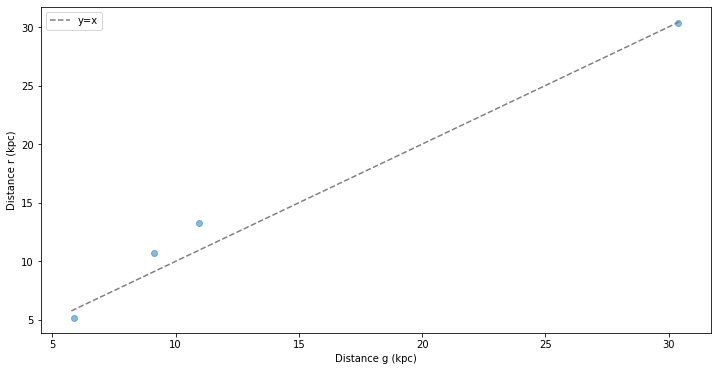

In [42]:
plot_properties(propx=rrl_sample['dist_g']/1000., propy=rrl_sample['dist_r']/1000.,
                propx_label="Distance g (kpc)", propy_label="Distance r (kpc)", dodiag=True)

A good agreement is obtained for the distances.

Now we will plot the absolute and apparent magnitudes of the RRL against their maximum and mean colors:

(17.845164899999997, 14.343471099999999)

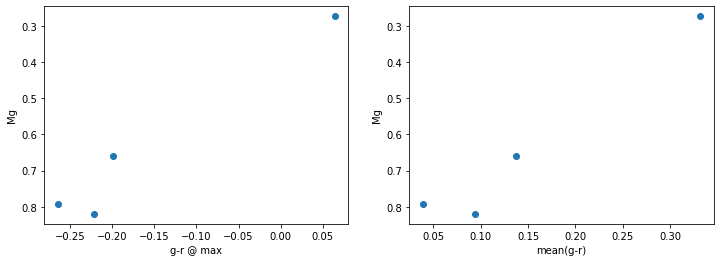

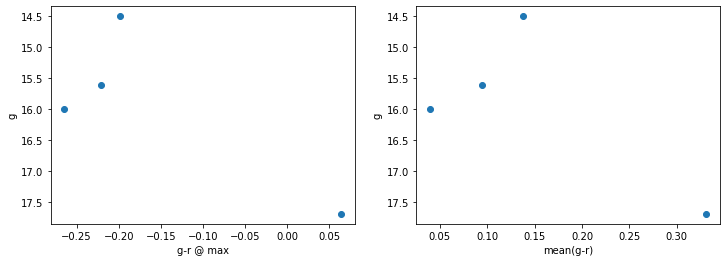

In [43]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].scatter(g_r_max_corr_ext_att, rrl_sample['Mg'])
ax[0].set_xlabel("g-r @ max")
ax[0].set_ylabel("Mg")
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[1].scatter(g_r_mean_corr_ext_att, rrl_sample['Mg'])
ax[1].set_xlabel("mean(g-r)")
ax[1].set_ylabel("Mg")
ax[1].set_ylim(ax[1].get_ylim()[::-1])

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].scatter(g_r_max_corr_ext_att, rrl_sample['mg'])
ax[0].set_xlabel("g-r @ max")
ax[0].set_ylabel("g")
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[1].scatter(g_r_mean_corr_ext_att, rrl_sample['mg'])
ax[1].set_xlabel("mean(g-r)")
ax[1].set_ylabel("g")
ax[1].set_ylim(ax[1].get_ylim()[::-1])

We want to compare the results of our color-magnitude diagram with data from the literature. We will compare to the work in Gaia Collaboration; Eyer et al. (2019, A&A, 623, A110). In order to do this, we need to convert our mean corrected $(g-r)$ color to the $(BP-RP)$ color, and the absolute magnitude, $M_g$ to $G$. We do this by following the correction function in Jordi et al. (2010, A&A, 523, A48) using:

$(BR-BP) = 0.3482 + 1.3463*(g-r) - 0.0310*(g-r)^2 + 0.0067*(g-r)^3$

$G = M_g - 0.0662 - 0.7854*(M_g-M_r) - 0.2859*(M_g-M_r)^2 + 0.0145*(M_g-M_r)^3$

In [44]:
print("mean(g-r) (mag) = ", g_r_mean_corr_ext_att)
gaiacolor = 0.3482 + 1.3463*g_r_mean_corr_ext_att - 0.031*g_r_mean_corr_ext_att**2 + 0.0067*g_r_mean_corr_ext_att**3
print("BR-BP (mag) = ", gaiacolor)
G = Mg - 0.0662 - 0.7854*(Mg-Mr) - 0.2859*(Mg-Mr)**2 + 0.0145*(Mg-Mr)**3
print("G (mag) = ", G)

mean(g-r) (mag) =  [0.3311072  0.0943803  0.03936173 0.13775094]
BR-BP (mag) =  [0.79081424 0.47499369 0.40114508 0.53308337]
G (mag) =  [0.09006468 0.6093332  0.47215239 0.4391347 ]


And now we can locate the RRL in our sample within the magnitude-color diagram in Gaia Collaboration; Eyer et al. (2019). In this figure we show in the left panel a diagram containing general classification of stars, and in the right panel a zoom-in with more specific classifications. The yellow square represents the area where our RRL are located, that we can see that fall in the area of RR Lyrae stars.

![RRL_GAIA_VS_Notebook](https://github.com/alercebroker/usecases/blob/master/notebooks/variablestars_figures/RRL_GAIA_VS_Notebook.png?raw=1)

As can be seen, our small sample of sources lies within the RRL lyrae population.

Finally, we will compare the periods obtained from the multiband period or from single band periods in g and r:

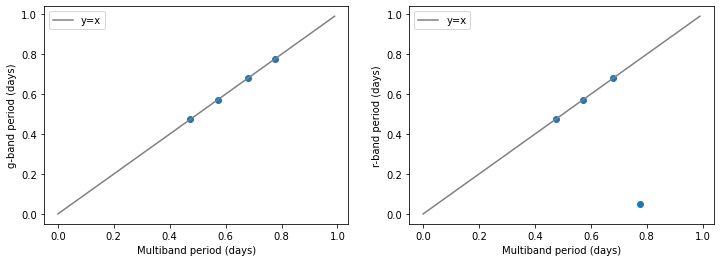

In [45]:
labels = {1: 'g', 2: 'r'}
t = np.arange(0.0, 1.0, 0.01)
s = t
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
        
for idx, fid in enumerate([1, 2]):
    if fid==1:
        ax[idx].scatter(rrl_sample['period_mb'], rrl_sample['period_g'])
    else:
        ax[idx].scatter(rrl_sample['period_mb'], rrl_sample['period_r'])
    ax[idx].set_xlabel("Multiband period (days)")
    ax[idx].set_ylabel("%s-band period (days)" % (labels[fid]))
    ax[idx].plot(t, s, c='gray', label="y=x")
    ax[idx].legend()

The agreement is very good, except for one of the sources, ZTF18aapmpdr, where the period estimated from the r-filter is lower than the multiband period.

### Using the ALeRCE client to query a larger sample of RRL <a class="anchor" id="clientrrl"></a>

In this example we will access the ALeRCE API to do a simple query to get information about a sample of 100 targets first detected at least 100 days after ZTF's 1st light, with a probability of being classified as RRL by the light curve classifier larger than 0.8, with a minimum of 100 detections, that will be ordered by their probability. We will output the result of the query directly as a pandas dataframe:

In [46]:
min_firstmjd = Time("2017-11-01T00:00:00", format="isot", scale="utc").mjd + 100

VSs = client.query_objects(classifier="lc_classifier",
                           class_name="RRL", 
                           probability=0.8,
                           ndet=[100,None],
                           order_by="probability",
                           order_mode="DESC",
                           first_mjd=[min_firstmjd, None],
                           count=False,
                           page_size=100, format='pandas')
print(VSs.shape)
VSs.head()

(100, 23)


,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF18aaajkxz,390,613,58101.466458,59538.463032,True,True,260,-0.480473,-0.093326,...,59538.463032,1111.924699,159.825257,20.587944,0.000064,0.000068,RRL,lc_classifier,0.994000,correction_1.0.6
1,ZTF18aabkmmz,824,1238,58129.369676,59550.343738,True,True,265,-0.093400,0.003369,...,59550.343738,1118.876759,138.892210,67.596347,0.000139,0.000043,RRL,lc_classifier,0.992012,correction_1.0.6
2,ZTF18aabkshf,940,1572,58095.556354,59531.485984,True,True,300,-0.347375,-0.120560,...,59531.485984,1289.227836,189.793667,32.998601,0.000067,0.000043,RRL,lc_classifier,0.992000,correction_1.0.6
3,ZTF18adalcju,199,299,58476.511632,59550.525579,True,True,176,-0.445504,-0.094659,...,59550.525579,1074.013947,178.870971,-8.553202,0.000104,0.000049,RRL,lc_classifier,0.990000,correction_1.0.6
4,ZTF17aaawlxc,395,712,58344.316007,59543.150393,True,True,270,-0.431532,-0.061791,...,59543.150393,1177.855718,338.258695,3.243225,0.000043,0.000051,RRL,lc_classifier,0.990000,correction_1.0.6


Here you can see the fields available in the dataframe

In [47]:
', '.join(list(VSs))

'oid, ndethist, ncovhist, mjdstarthist, mjdendhist, corrected, stellar, ndet, g_r_max, g_r_max_corr, g_r_mean, g_r_mean_corr, firstmjd, lastmjd, deltajd, meanra, meandec, sigmara, sigmadec, class, classifier, probability, step_id_corr'

So we can define a histogram to check the distributions of these parameters.

For example, here we show the distribution of the maximum g-r color:

Text(0, 0.5, 'Frequency')

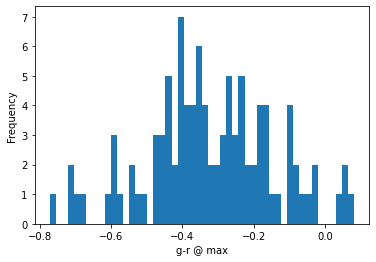

In [48]:
fig, ax = plt.subplots()
ax.hist(VSs.g_r_max, bins=50)
ax.set_xlabel("g-r @ max")
ax.set_ylabel("Frequency")

Or the number of detections for the sample of variable stars:

Text(0.5, 0, 'N. detections')

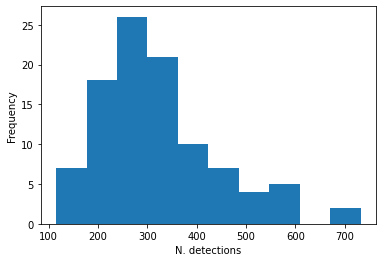

In [49]:
fig, ax = plt.subplots()
VSs.ndet.plot.hist(ax=ax)
ax.set_xlabel("N. detections")

And we will also plot these properties using the function that we defined previously.

Here we show their mean corrected colors, g_r_mean_corr, versus their maximum corrected colors, g_r_max_corr:

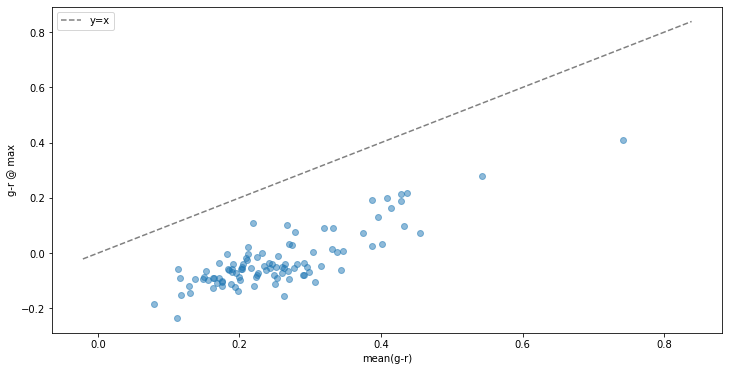

In [50]:
plot_properties(propx=VSs.g_r_mean_corr, propy=VSs.g_r_max_corr,
                propx_label="mean(g-r)", propy_label="g-r @ max", dodiag=True)

As expected, the maximum colors are bluer that the mean values. This is because the stars move in diagonal loops in color-magnitude plots.

Finally, we try some random stars from the selected sample:

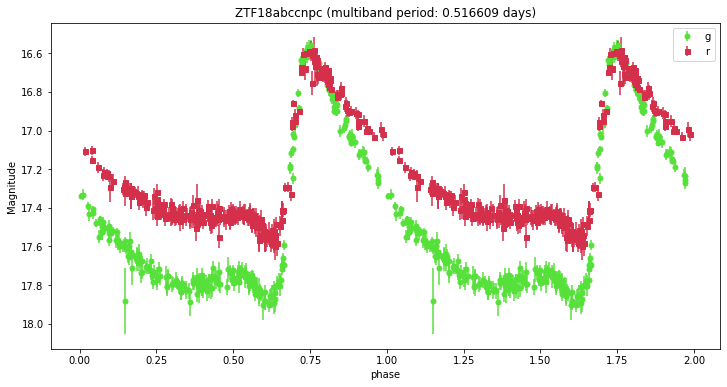

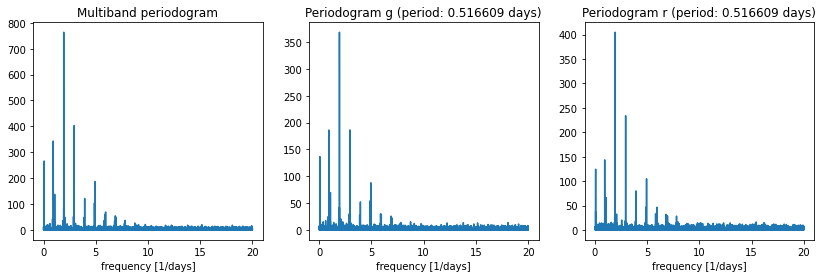

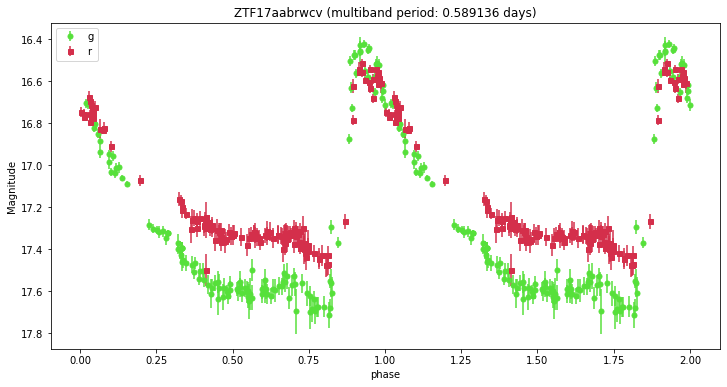

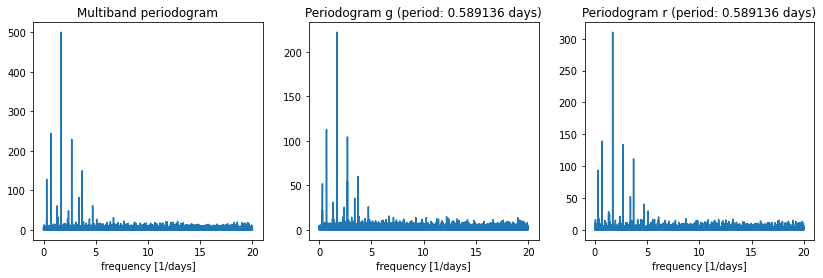

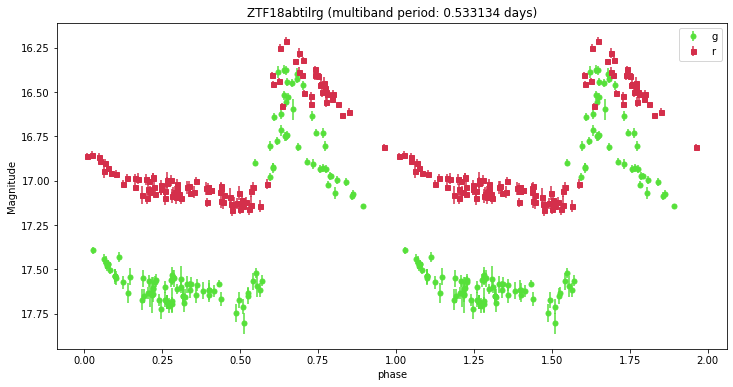

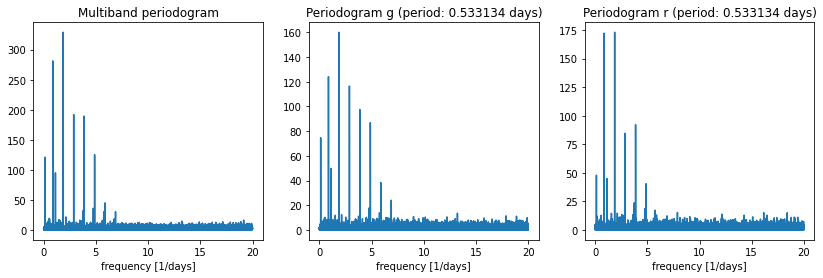

In [51]:
for oid in np.random.choice(VSs.oid, size=3):
    results = getVSdatacorr(oid)
    periodogram = getLCdata(oid, results, doplot=True, dofold=True, showperiodograms=True)
    show_image(results)

#### Plot the light curve amplitude vs period <a class="anchor" id="amplitudevsperiod"></a>

We want to obtain a plot of the light curve amplitude as a function of period for our sample. When computing the light curve amplitude, we could simply use the maximum and minimum magnitude values in each band. However, we want to discard magnitude outliers, like the ones found in the light curve for the source ZTF18aajusiz (presented in a previous section):

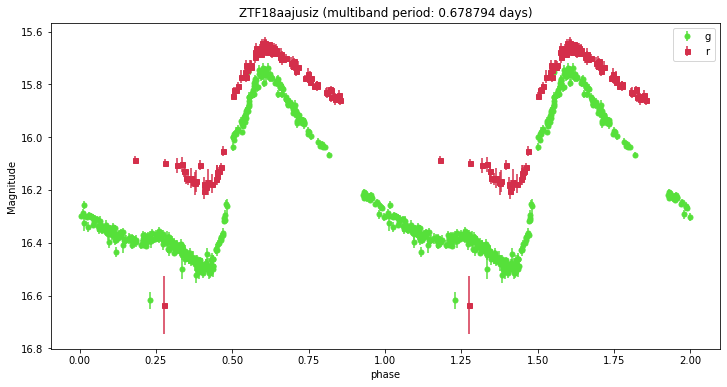

In [52]:
seloid = "ZTF18aajusiz"
results = getVSdatacorr(seloid)
periodogram = getLCdata(seloid, results, doplot=True, dofold=True)

Thus we compute the amplitude using magnitudes within percentiles 5 and 95 in each band. Note that this works for the mentioned source, as we show in the g and r band magnitude histograms below (vertical dashed lines indicate the limiting percentiles):

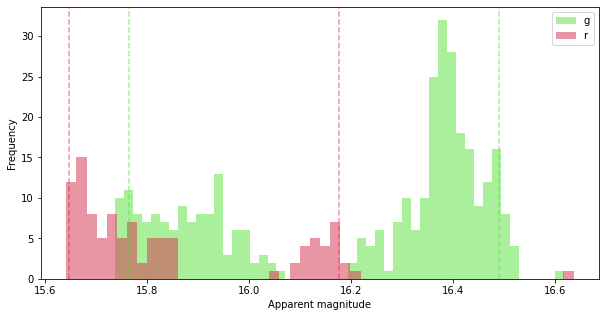

In [53]:
percentile_left = 5.
percentile_right = 95.

mags, fids = results["lc_det"][["magpsf_corr", "fid"]].dropna().values.T

fig, ax = plt.subplots(figsize = (10, 5))
labels = {1: 'g', 2: 'r'}

for fid in [1, 2]:
    mask = fids == fid
    perc_left = np.percentile(mags[mask], percentile_left)
    perc_right = np.percentile(mags[mask], percentile_right)
    
    ax.hist(mags[mask], bins=50, label=labels[fid], color=colors[fid], alpha=0.5)
    ax.axvline(x=perc_left, linestyle='--', color=colors[fid], alpha=0.5)
    ax.axvline(x=perc_right, linestyle='--', color=colors[fid], alpha=0.5)

ax.set_xlabel("Apparent magnitude")
ax.set_ylabel("Frequency")
ax.legend()

Computing the multiband period in the way shown previously can be time consuming for a large sample of sources. The light curve classifier uses variability features computed from the ZTF alert stream, and among these features we find one called `Multiband_period`. This is a period obtained using the MHAOV periodogram mentioned before. We will thus query this feature for each source in our sample.

In [54]:
seloid = VSs.oid
noid = len(seloid)
period_feature = np.zeros(noid)

for i, oid in enumerate(seloid):
    VS_features = client.query_feature(oid, name="Multiband_period", format='pandas')
    period_feature[i] = VS_features.value

We now obtain the amplitude for the sources in our sample. WARNING: this might take some time to run...

In [55]:
seloid = VSs.oid
noid = len(seloid)

percentile_left = 5.
percentile_right = 95.

amplitude = np.zeros((noid, 2))

for i, oid in enumerate(seloid):
    results = getVSdatacorr(oid)
    mags, fids = results["lc_det"][["magpsf_corr", "fid"]].dropna().values.T
    
    for fid in [1, 2]:
        mask = fids == fid
        perc_left = np.percentile(mags[mask], percentile_left)
        perc_right = np.percentile(mags[mask], percentile_right)
        
        amplitude[i, fid-1] = perc_right - perc_left

And we finally show the plot:

Text(0, 0.5, 'Amplitude (mag)')

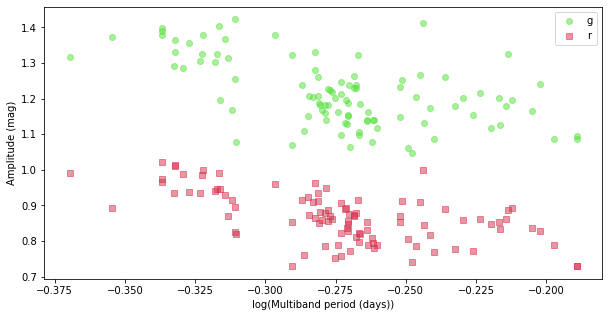

In [56]:
labels = {1: 'g', 2: 'r'}
markers = {1: 'o', 2: 's'}

fig, ax = plt.subplots(figsize = (10, 5))

for fid in [1, 2]:
    ax.scatter(np.log10(period_feature), amplitude[:, fid-1], c=colors[fid], marker=markers[fid],
               label=labels[fid], alpha=0.5)

ax.legend()
ax.set_xlabel("log(Multiband period (days))")
ax.set_ylabel("Amplitude (mag)")

If we compare with larger samples of RRL, as e.g. with Sánchez-Sáez et al. (2021), we note that mostly ab-type RRL are present in this sample of 100 sources (periods longer than 0.5 days). This happens because the RRL class in our labeled set is dominated by ab-type RRL (they comprise around its 80%), and thus the light curve classifier identifies them more easily.

### Using the ALeRCE database (DB) to query a sample of RRL <a class="anchor" id="dbrrl"></a>

The previous way of querying candidates is good for relatively simple queries. However, if we want to do more complex queries the best solution may be to connect directly to the DB. We show how to do this here. You will need to use the read only credentials available in the repository

In [57]:
import requests
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']

Now we open a connection to the DB

In [58]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

And we show all the available tables

In [59]:
query = """
SELECT table_name FROM information_schema.tables
WHERE table_schema='alerce'
ORDER BY table_name;
"""
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="table_name")

,table_name
0,allwise
1,dataquality
2,detection
3,feature
4,feature_version
5,gaia_ztf
6,lc_classifier
7,lc_classifier_periodic
8,lc_classifier_stochastic
9,lc_classifier_top


You can see all the tables used in the new version of our database. The most relevant tables are, moving from less to more aggregation:

* `non_detection`: one row per non-detection per object, the limiting magnitudes
* `detections`: one row per detection, light curves and other relevant time dependent information
* `dataquality`: one row per detection, data quality related time dependent information
* `magstat`: one row per object per filter, statistics per bandpass per object
* `object`: one row per object, basic object statistics
* `probability`: one row per object per classifier and class, the probabilities of every object
* `reference`: one row per object per reference image, object statistics for every reference image used
* `feature`: one row per object per feature, object computed features
* `xmatch`: one row per object per external catalog, the table that points to the detailed xmatch tables
* `allwise, ps1_ztf, gaia_ztf, ss_stf`: one row per object, xmatch tables


For completeness, we now show all columns available in all tables:

In [60]:
alltabs = []
for tab in sorted(tables.table_name):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,allwise,k_msig_2mass,double precision
1,allwise,ra,double precision
2,allwise,dec,double precision
3,allwise,w1mpro,double precision
4,allwise,w2mpro,double precision
5,allwise,w3mpro,double precision
6,allwise,w4mpro,double precision
7,allwise,w1sigmpro,double precision
8,allwise,w2sigmpro,double precision
9,allwise,w3sigmpro,double precision


Now we can do a query asking for RRL candidates. For this it is important to understand the `probability` table. This table contains all the classifications probabilities, for every object, every classifier, and every available class. An object will be in many rows of this table, with the idea of being flexible to future changes in the taxonomy.

For example, an object classified by the light curve classifier (classifier_name = lc_classifier) will appear in all the available classes, e.g., class_name = 'SNIa' or class_name = 'AGN', independently of whether this is the most likely class. The most likely class can be quickly obtained with the ranking column (ranking = 1). For example, if we want to find the probabilities of the objects most likely to be RR Lyrae, we would look for objects with classifier_name = 'lc_classifier', class_name = 'RRL' and ranking = 1. The probabilities will be given by the probability column.

We will query objects that are most likely to be RRL with a probability larger than 0.55 and have 100 or more detections. For this we will do a complex query, including an inner join between object and probability and selecting those oids to be considered from probability.

In [61]:
query='''
SELECT
    object.oid, object.meanra, object.meandec, object.ndet,
    object.firstMJD, object.deltajd, object.g_r_max,
    probability.classifier_name, probability.class_name,
    probability.ranking, probability.probability
FROM
    object INNER JOIN probability
    ON object.oid = probability.oid
WHERE
    probability.classifier_name = 'lc_classifier'
    AND object.ndet >= 100
    AND object.oid IN 
(
SELECT
    oid
FROM
    probability
WHERE
    classifier_name = 'lc_classifier'
    AND class_name IN ('RRL')
    AND ranking = 1
    AND probability > 0.55
)
'''

VSs = pd.read_sql_query(query, conn)
print(VSs.shape)
VSs.set_index('oid', inplace=True)

(453060, 11)


Let's look at the first 20 rows in this dataframe:

In [62]:
VSs.head(20)

,meanra,meandec,ndet,firstmjd,deltajd,g_r_max,classifier_name,class_name,ranking,probability
oid,,,,,,,,,,
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,AGN,9,0.000008
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,Blazar,8,0.000028
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,CEP,2,0.147704
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,CV/Nova,6,0.001180
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,DSCT,5,0.009980
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,E,3,0.027944
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,LPV,10,0.000000
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,Periodic-Other,4,0.015968
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,QSO,9,0.000008


And now let's look at all the rows where the first VS above appears:

In [63]:
VSs.loc[VSs.iloc[[0]].index]

,meanra,meandec,ndet,firstmjd,deltajd,g_r_max,classifier_name,class_name,ranking,probability
oid,,,,,,,,,,
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,AGN,9,0.000008
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,Blazar,8,0.000028
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,CEP,2,0.147704
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,CV/Nova,6,0.001180
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,DSCT,5,0.009980
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,E,3,0.027944
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,LPV,10,0.000000
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,Periodic-Other,4,0.015968
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,QSO,9,0.000008


We will create a short function to convert the probabilities and rankings into columns, with one row per object. 

In [64]:
def merge_probs(df):
    dfnew = df.copy().iloc[[0]].drop(["class_name", "ranking", "probability"], axis=1)
    for cl in df.class_name.unique():
        mask = df.class_name == cl
        dfnew["%s_prob" % cl] = df.loc[mask].probability
        dfnew["%s_rank" % cl] = df.loc[mask].ranking
    return dfnew

In [65]:
merge_probs(VSs.loc[VSs.iloc[[0]].index])

,meanra,meandec,ndet,firstmjd,deltajd,g_r_max,classifier_name,AGN_prob,AGN_rank,Blazar_prob,...,SLSN_prob,SLSN_rank,SNIa_prob,SNIa_rank,SNIbc_prob,SNIbc_rank,SNII_prob,SNII_rank,YSO_prob,YSO_rank
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abstbcb,267.455259,-14.245208,115,58365.229687,1125.918611,0.702729,lc_classifier,0.000008,9,0.000028,...,0.0,10,0.0,10,0.0,10,0.0,10,0.000776,7


We see here that the result is only one row per oid.

You could apply it to the entire dataframe, but it can take too long, so we leave it commented...

In [66]:
#VSprobs = VSs.groupby("oid").apply(merge_probs)
#VSprobs.reset_index(level=1, drop=True, inplace=True)
#VSprobs.head()

Here we show a list of the parameters in the table VSprobs, that you can uncomment in case you run the previous commands:

In [67]:
#list(VSprobs)

Now we plot an histogram of the source probabilities of being finally classified as RRL:

Text(0, 0.5, 'Frequency')

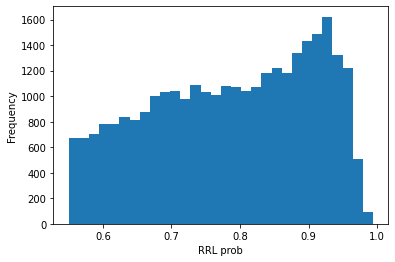

In [68]:
fig, ax = plt.subplots()
mask = (VSs.ranking == 1) & (VSs.class_name == "RRL")
ax.hist(VSs.loc[mask].probability, bins=30)
ax.set_xlabel("RRL prob")
ax.set_ylabel("Frequency")

And we check how many RRL are found:

In [69]:
mask = (VSs.ranking == 1) & (VSs.class_name == "RRL")
rrl_sample = VSs.loc[mask]

print("Number of RRL", len(rrl_sample))

Number of RRL 30204


Finally, we will plot the number of detections against the number of days between the last and first ZTF detections for these sources:

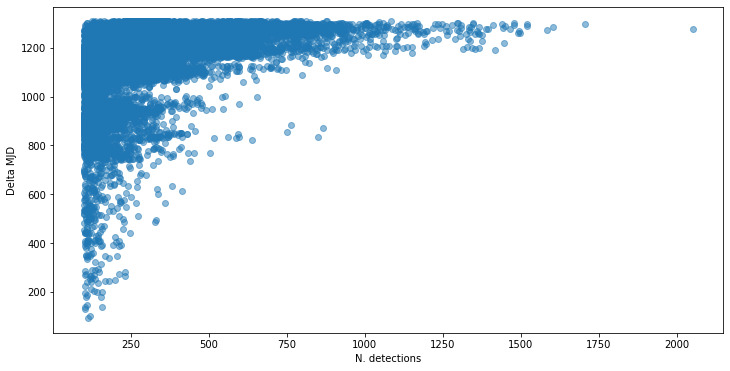

In [70]:
plot_properties(propx=VSs.loc[mask].ndet, propy=VSs.loc[mask].deltajd,
                propx_label="N. detections", propy_label="Delta MJD")

#### Query object computed features<a class="anchor" id="features"></a>

Our light curve classifier uses variability features computed from the ZTF alert stream. Two relevant features are `Multiband_period`, the multiband period introduced in a previous section, and `Amplitude`, which is defined as the half of the difference between the median of the maximum 5 percent and the median of the minimum 5 percent magnitudes (then we use twice the obtained value as the light curve amplitude). Let's query the feature names from the `feature` table.

In [71]:
rrl_oids = rrl_sample.index.values

query='''
SELECT
    *
FROM
    feature
WHERE
    (name='Amplitude'
    OR name='Multiband_period')
    AND oid in (%s)
''' % ",".join(["'%s'" % oid for oid in rrl_oids])

rrl_features = pd.read_sql_query(query, conn)
rrl_features.set_index('oid', inplace=True)
rrl_features.head()

,name,value,fid,version
oid,,,,
ZTF17aaaabhx,Amplitude,0.639678,1,lc_classifier_1.2.1-P
ZTF17aaaabhx,Amplitude,0.419974,2,lc_classifier_1.2.1-P
ZTF17aaaabhx,Multiband_period,0.592232,12,lc_classifier_1.2.1-P
ZTF17aaaabtj,Multiband_period,0.325856,12,lc_classifier_1.2.1-P
ZTF17aaaabtj,Amplitude,0.293612,1,lc_classifier_1.2.1-P


With these features we can plot the mean variance for each filter as a function of the multiband period:

In [72]:
mask = rrl_features.name == "Multiband_period"
rrl_period_mb = rrl_features.loc[mask]

mask = (rrl_features.name == "Amplitude") & (rrl_features.fid==1)
rrl_amplitude_g = rrl_features.loc[mask]

mask = (rrl_features.name == "Amplitude") & (rrl_features.fid==2)
rrl_amplitude_r = rrl_features.loc[mask]

Text(0, 0.5, 'Amplitude (mag)')

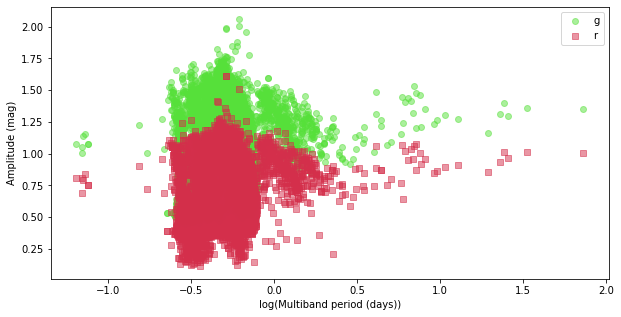

In [73]:
labels = {1: 'g', 2: 'r'}
markers = {1: 'o', 2: 's'}

fig, ax = plt.subplots(figsize = (10, 5))

for fid in [1, 2]:
    if fid==1:
        amplitude = rrl_amplitude_g.value*2.
    else:
        amplitude = rrl_amplitude_r.value*2.
    
    ax.scatter(np.log10(rrl_period_mb.value), amplitude, c=colors[fid], marker=markers[fid],
               label=labels[fid], alpha=0.5)

ax.legend()
ax.set_xlabel("log(Multiband period (days))")
ax.set_ylabel("Amplitude (mag)")

From our plot and these figures we can distinguish two RRL sub-populations, namely ab-type and c-type RRL, which lie around log(multiband period) values of -0.25 and -0.5, respectively. As mentioned previously, note that the number of sources classified as ab-type RRL is far larger than that of c-type RRL. For details see Sánchez-Sáez et al. (2021).

We can now display example light curves for each sub-population, taking e.g. the source with the (current) largest number of detections and log(multiband period) around the values mentioned before. First we gather the data in a pandas dataframe, and create subsets of sources for given log(multiband period) intervals:

In [74]:
rrl_period_mb = rrl_period_mb.drop(columns=['name', 'fid', 'version'])
rrl_period_mb.rename(columns={'value': 'Multiband_period'}, inplace=True)
rrl_amplitude_g = rrl_amplitude_g.drop(columns=['name', 'fid', 'version'])
rrl_amplitude_g.rename(columns={'value': 'Amplitude_g'}, inplace=True)
rrl_amplitude_r = rrl_amplitude_r.drop(columns=['name', 'fid', 'version'])
rrl_amplitude_r.rename(columns={'value': 'Amplitude_r'}, inplace=True)
rrl_sample_features = pd.concat([rrl_sample, rrl_period_mb, rrl_amplitude_g, rrl_amplitude_r],
                                axis=1, sort=True)
rrl_sample_features.head()

,meanra,meandec,ndet,firstmjd,deltajd,g_r_max,classifier_name,class_name,ranking,probability,Multiband_period,Amplitude_g,Amplitude_r
oid,,,,,,,,,,,,,
ZTF17aaaabhx,76.596245,53.758433,541,58345.429410,1196.891482,0.227606,lc_classifier,RRL,1,0.648088,0.592232,0.639678,0.419974
ZTF17aaaabtj,30.542627,32.079501,324,58361.451007,1167.872720,0.520600,lc_classifier,RRL,1,0.798400,0.325856,0.293612,0.216283
ZTF17aaaacgg,71.328606,57.081867,455,58345.429410,1196.773322,0.391637,lc_classifier,RRL,1,0.750496,0.548325,0.578377,0.409977
ZTF17aaaaclo,70.853230,7.201666,191,58443.265602,1089.115590,-0.359678,lc_classifier,RRL,1,0.616764,0.304736,0.268623,0.187054
ZTF17aaaacpo,68.541447,7.321927,226,58450.400706,1079.973079,-0.153200,lc_classifier,RRL,1,0.828000,0.577244,0.471539,0.376236


In [75]:
rrlab_logperiod_typical = -0.25
rrlc_logperiod_typical = -0.5
delta_logperiod = 0.02

rrlab = rrl_sample_features[:][(np.log10(rrl_sample_features.Multiband_period)>rrlab_logperiod_typical-delta_logperiod) &
    (np.log10(rrl_sample_features.Multiband_period)<rrlab_logperiod_typical+delta_logperiod)]

rrlc = rrl_sample_features[:][(np.log10(rrl_sample_features.Multiband_period)>rrlc_logperiod_typical-delta_logperiod) &
    (np.log10(rrl_sample_features.Multiband_period)<rrlc_logperiod_typical+delta_logperiod)]

Now we find the identifiers of the sources having the largest number of detections in each subset, and plot their folded light curves:

In [76]:
oid_rrlab_example = rrlab.ndet.idxmax()
oid_rrlc_example = rrlc.ndet.idxmax()
seloid = [oid_rrlab_example, oid_rrlc_example]

rrl_sample_features.loc[seloid].head()

,meanra,meandec,ndet,firstmjd,deltajd,g_r_max,classifier_name,class_name,ranking,probability,Multiband_period,Amplitude_g,Amplitude_r
oid,,,,,,,,,,,,,
ZTF17aaaecwh,340.560323,51.300519,2050,58272.466192,1277.769340,-0.24789,lc_classifier,RRL,1,0.806384,0.579286,0.518188,0.377417
ZTF18abaeadn,286.193487,72.620492,1040,58281.456215,1261.684282,-0.01515,lc_classifier,RRL,1,0.621180,0.310072,0.255690,0.193351


/home/ammunoz1/.local/lib/python3.7/site-packages/P4J-1.0.0-py3.7-linux-x86_64.egg/P4J/periodograms.py:64: RuntimeWarning: divide by zero encountered in true_divide
  per_single_band.update({filter_name : (d2/d1)*per/(self.cython_per[filter_name].wvar-per)})


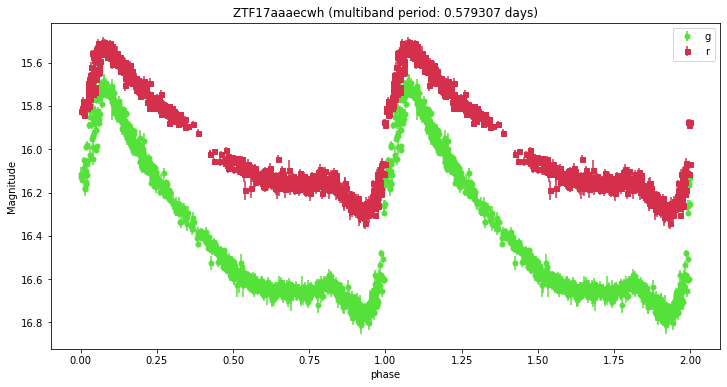

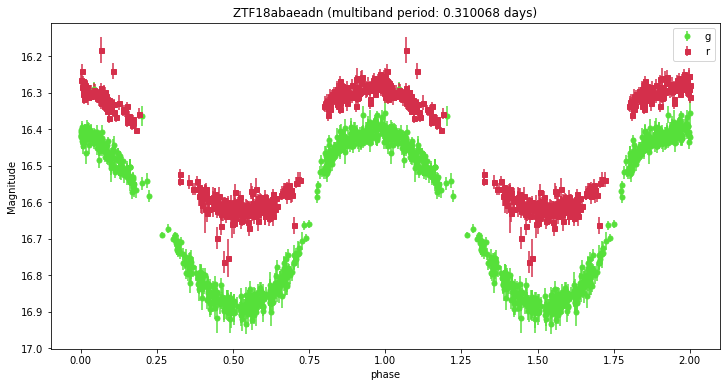

In [77]:
for oid in seloid:
    results = getVSdatacorr(oid)
    periodogram = getLCdata(oid, results, doplot=True, dofold=True)

Finally, we close the connection to the DB:

In [78]:
conn.close()